In [1]:
import random
import numpy as np
import pandas as pd
import copy
import time
from sklearn.preprocessing import OneHotEncoder


In [2]:
class Network(object):

    def __init__(self, sizes):
        

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
        # helper variables
        self.bias_nitem = sum(sizes[1:])
        self.weight_nitem = sum([self.weights[i].size for i in range(self.num_layers-2)])

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w,a)+b)
        return a

    def sigmoid(self, z):
        return 1.0/(1.0+np.exp(-z))

    def score(self, X, y):

        total_score=0
        for i in range(X.shape[0]):
            predicted = self.feedforward(X[i].reshape(-1,1))
            actual = y[i].reshape(-1,1)
            total_score += np.sum(np.power(predicted-actual,2)/2)  # mean-squared error
        return total_score

    def accuracy(self, X, y):


        accuracy = 0
        for i in range(X.shape[0]):
            output = self.feedforward(X[i].reshape(-1,1))
            accuracy += int(np.argmax(output) == np.argmax(y[i]))
        return accuracy / X.shape[0] * 100

    def __str__(self):
        s = "\nBias:\n\n" + str(self.biases)
        s += "\nWeights:\n\n" + str(self.weights)
        s += "\n\n"
        return s

In [3]:
class NNGeneticAlgo:

    def __init__(self, n_pops, net_size, mutation_rate, crossover_rate, retain_rate, X, y):

        self.n_pops = n_pops
        self.net_size = net_size
        self.nets = [Network(self.net_size) for i in range(self.n_pops)]
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.retain_rate = retain_rate
        self.X = X[:]
        self.y = y[:]
    
    def get_random_point(self, type):


        nn = self.nets[0]
        layer_index, point_index = random.randint(0, nn.num_layers-2), 0
        if type == 'weight':
            row = random.randint(0,nn.weights[layer_index].shape[0]-1)
            col = random.randint(0,nn.weights[layer_index].shape[1]-1)
            point_index = (row, col)
        elif type == 'bias':
            point_index = random.randint(0,nn.biases[layer_index].size-1)
        return (layer_index, point_index)

    def get_all_scores(self):
        return [net.score(self.X, self.y) for net in self.nets]

    def get_all_accuracy(self):
        return [net.accuracy(self.X, self.y) for net in self.nets]

    def crossover(self, father, mother):

        # make a copy of father 'genetic' weights & biases information
        nn = copy.deepcopy(father)

        # cross-over bias
        for _ in range(self.nets[0].bias_nitem):
            # get some random points
            layer, point = self.get_random_point('bias')
            # replace genetic (bias) with mother's value
            if random.uniform(0,1) < self.crossover_rate:
                nn.biases[layer][point] = mother.biases[layer][point]

        # cross-over weight
        for _ in range(self.nets[0].weight_nitem):
            # get some random points
            layer, point = self.get_random_point('weight')
            # replace genetic (weight) with mother's value
            if random.uniform(0,1) < self.crossover_rate:
                nn.weights[layer][point] = mother.weights[layer][point]
        
        return nn
        
    def mutation(self, child):

        nn = copy.deepcopy(child)

        # mutate bias
        for _ in range(self.nets[0].bias_nitem):
            # get some random points
            layer, point = self.get_random_point('bias')
            # add some random value between -0.5 and 0.5
            if random.uniform(0,1) < self.mutation_rate:
                nn.biases[layer][point] += random.uniform(-0.5, 0.5)

        # mutate weight
        for _ in range(self.nets[0].weight_nitem):
            # get some random points
            layer, point = self.get_random_point('weight')
            # add some random value between -0.5 and 0.5
            if random.uniform(0,1) < self.mutation_rate:
                nn.weights[layer][point[0], point[1]] += random.uniform(-0.5, 0.5)

        return nn

    def evolve(self):

        # calculate score for each population of neural-net
        score_list = list(zip(self.nets, self.get_all_scores()))

        # sort the network using its score
        score_list.sort(key=lambda x: x[1])

        # exclude score as it is not needed anymore
        score_list = [obj[0] for obj in score_list]

        # keep only the best one
        retain_num = int(self.n_pops*self.retain_rate)
        score_list_top = score_list[:retain_num]

        # return some non-best ones
        retain_non_best = int((self.n_pops-retain_num) * self.retain_rate)
        for _ in range(random.randint(0, retain_non_best)):
            score_list_top.append(random.choice(score_list[retain_num:]))

        # breed new childs if current population number less than what we want
        while len(score_list_top) < self.n_pops:

            father = random.choice(score_list_top)
            mother = random.choice(score_list_top)

            if father != mother:
                new_child = self.crossover(father, mother)
                new_child = self.mutation(new_child)
                score_list_top.append(new_child)
        
        # copy our new population to current object
        self.nets = score_list_top


In [4]:
def main():

    df2 = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
    #normalising the dataset as otherwise it creates a runtime error of overflow due to the sigmoid function
    df_norm = (df2-df2.min())/(df2.max()-df2.min())
    df_norm = df_norm.drop(['ID','ZIP Code','Online','CCAvg','Mortgage','Experience'],axis = 1)
    X = df_norm.iloc[:, :-1].values
    y = df_norm.iloc[:, -1].values

    # convert y into one-hot encoded format
    y = y.reshape(-1, 1)
    enc = OneHotEncoder()
    enc.fit(y)
    y = enc.transform(y).toarray()

    # parameters
    N_POPS = 32
    NET_SIZE = [7,6,5,2]
    MUTATION_RATE = 0.3
    CROSSOVER_RATE = 0.4
    RETAIN_RATE = 0.4

    # start our neural-net & optimize it using genetic algorithm
    nnga = NNGeneticAlgo(N_POPS, NET_SIZE, MUTATION_RATE, CROSSOVER_RATE, RETAIN_RATE, X, y)

    start_time = time.time()
    
    # run for n iterations
    for i in range(20):

        if i % 1 == 0:
            print("Current iteration : {}".format(i+1))
            print("Time taken by far : %.1f seconds" % (time.time() - start_time))
            print("Current top member's network accuracy: %.2f%%\n" % nnga.get_all_accuracy()[0])

        # evolve the population
        nnga.evolve()

if __name__ == "__main__":
    main()

Current iteration : 1
Time taken by far : 0.0 seconds
Current top member's network accuracy: 70.88%

Current iteration : 2
Time taken by far : 8.6 seconds
Current top member's network accuracy: 70.60%

Current iteration : 3
Time taken by far : 17.0 seconds
Current top member's network accuracy: 70.60%

Current iteration : 4
Time taken by far : 25.4 seconds
Current top member's network accuracy: 70.60%

Current iteration : 5
Time taken by far : 33.9 seconds
Current top member's network accuracy: 70.60%

Current iteration : 6
Time taken by far : 42.3 seconds
Current top member's network accuracy: 70.60%

Current iteration : 7
Time taken by far : 51.0 seconds
Current top member's network accuracy: 70.60%

Current iteration : 8
Time taken by far : 60.0 seconds
Current top member's network accuracy: 70.60%

Current iteration : 9
Time taken by far : 69.4 seconds
Current top member's network accuracy: 70.60%

Current iteration : 10
Time taken by far : 77.8 seconds
Current top member's network

In [36]:
df = pd.read_csv("iris.csv")

In [37]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [47]:
df2 = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
df_norm = (df2-df2.min())/(df2.max()-df2.min())
df_norm = df_norm.drop(['ID','ZIP Code','Online','CCAvg'],axis = 1)

In [48]:
df_norm.head()

,Age,Experience,Income,Family,Education,Mortgage,Personal Loan,Securities Account,CD Account,CreditCard
0,0.045455,0.086957,0.189815,1.000000,0.0,0.0,0.0,1.0,0.0,0.0
1,0.500000,0.478261,0.120370,0.666667,0.0,0.0,0.0,1.0,0.0,0.0
2,0.363636,0.391304,0.013889,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.272727,0.260870,0.425926,0.000000,0.5,0.0,0.0,0.0,0.0,0.0
4,0.272727,0.239130,0.171296,1.000000,0.5,0.0,0.0,0.0,0.0,1.0


In [55]:
import seaborn as sns

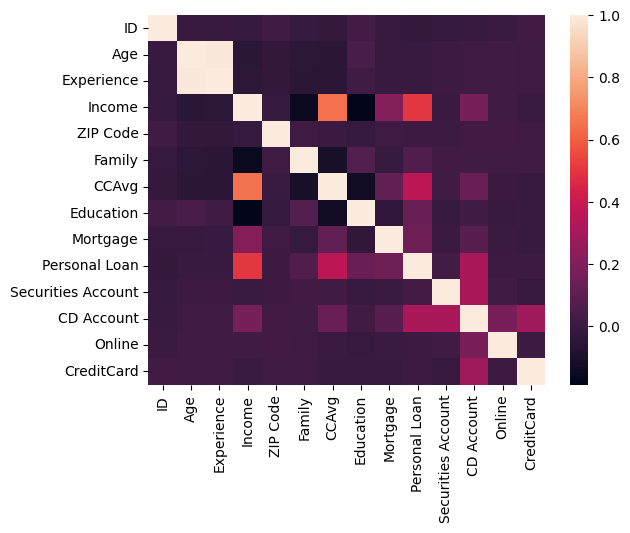

In [56]:
corelation_values = df2.corr()

corr_heatmap = sns.heatmap(corelation_values, xticklabels=df2.columns, yticklabels=df2.columns)